# Ön Bilgi
**Geliştirenler :** Onur Kantar - Ömer Resul Ertan

**Veri Kümesinin İçeriği :** 3 farklı sınıfa ait toplamda 3000 tweet bulunmaktadır.

**Tweet Sınıfları :** 

-	Olumlu Tweetler
-	Olumsuz Tweetler
-	Nötr Tweetler

**Veri Kümesi Referansı :** "Eğiticili ve Geleneksel Terim Ağırlıklandırma Yöntemleriyle Duygu Analizi", Mahmut Çetin, M.Fatih Amasyalı, SIU 2013, KKTC

**Algoritma :** Word2Vec

**Ağ Mimarisi :** 

- Embedding(500)
- LSTM(150)
- Dense(3)

batch_size = 16

epochs = 3

~%87 doğruluk oranı elde ediliyor.

In [1]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Activation, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# Veri Kümemizi Ekleyelim : 

In [2]:
tweets = pd.read_csv("3000tweet/3000tweet.csv", sep=';', encoding="utf8")

# Veri Kümemizi Tanıyalım : 

In [3]:
tweets

,tweet,durum
0,dun Turkcelle tepkilerimizden sonra bugün Turk...,1
1,girmezmiyim.. Turkcell kartim bile var.. Yarin...,1
2,tam tünelden gecerken 3g cekiyordu :D türkcell...,1
3,turkcell superonline fiber internet veya ADSL ...,1
4,bence Gnçtrkcll Ark Winterfest 2012'de 1.olur ...,1
...,...,...
2995,Evet kesinlikle çok az.. Turkcell bu konuda şu...,3
2996,selocan nedir abicim ya ?,3
2997,özturkcell e dönücz diye korkuyorum ama çanakk...,3
2998,turkcell se 532 yi ara puk kodunu ogrenme menu...,3


# Veri Kümemizi Düzenleyelim : 

### NULL Değerleri Silme İşlemi : 

In [4]:
tweets.isnull().sum()

tweet    1
durum    0
dtype: int64

In [5]:
tweets = tweets.dropna().reset_index(drop=True)
tweets.isnull().sum()

tweet    0
durum    0
dtype: int64

### Gereksiz Kelimeleri - Boşukları - İşaretleri Silme İşlemleri :  

In [6]:
stop_word_list = stopwords.words('turkish')
stop_word_list

['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mi',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [7]:
def preprocess_text(sen):
    
    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sen))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [8]:
x = tweets['tweet']
y = tweets['durum']

In [9]:
x = x.apply(preprocess_text)
pd.DataFrame(data=x)

,tweet
0,dun turkcelle tepkilerimizden sonra bugün turk...
1,girmezmiyim turkcell kartim bile var yarindan ...
2,tam tünelden gecerken cekiyordu türkcell in re...
3,turkcell superonline fiber internet adsl sabit...
4,bence gnçtrkcll ark winterfest olur gelir
...,...
2994,evet kesinlikle turkcell konuda an uygun değil...
2995,selocan nedir abicim
2996,özturkcell dönücz korkuyorum çanakkale holding...
2997,turkcell se yi ara puk kodunu ogrenme menusund...


### Kelimeleri Ayıralım ve Kelime Hazinesi Oluşturalım : 

In [10]:
words = []
for i in x:
    words.append(i.split())

print(words[0])

['dun', 'turkcelle', 'tepkilerimizden', 'sonra', 'bugün', 'turkcell', 'twittera', 'sponsor', 'olmuş', 'ne', 'tesadüf', 'değil']


Şimdi Word2Vec, "words" dizisindeki tüm benzersiz kelimeleri alacak, böylece kelime hazinesi inşa edecek.

In [11]:
word2vec_model = Word2Vec(words, size=150, window=3, min_count=1, workers=16)
print(word2vec_model)

Word2Vec(vocab=11748, size=150, alpha=0.025)


Aşağıda, bir Word2Vec modelini tanımlamak için kullandığımız dört parametrenin tanımını sağlıyorum:

- **size :** Sözcük vektörlerinin boyutsallığı anlamına gelir. Her bir kelimeyi temsil etmek için kullanılan belirteçlerin sayısını tanımlar. 

    - **Pratik kural :** Bir veri kümesi küçükse, boyut da küçük olmalıdır. Bir veri kümesi büyükse, boyut da daha büyük olmalıdır.


- **window :** Hedef sözcük ile komşu sözcüğü arasındaki maksimum mesafe. Örneğin, 5 kelimeyle "Turkcell harika bir iletişim operatörü" ifadesini alalım. Pencere boyutu 3 ise, "Turkcell" kelimesinin vektörü "harika", "bir" ve "iletişim" kelimelerinden doğrudan etkilenir.
    - **Pratik kural :** Daha küçük bir pencere daha alakalı terimler sağlamalıdır
    
    
- **min_count :** Toplam frekansı bundan daha düşük olan tüm kelimeleri yok sayar. Örneğin, kelime sıklığı aşırı derecede düşükse, bu kelime önemsiz olarak kabul edilebilir.


- **workers :** Modeli eğitmek için kullanılan işçi, iş parçacığı sayısı.



In [12]:
print(word2vec_model)

Word2Vec(vocab=11748, size=150, alpha=0.025)


### Kelimeleri Vectörlere Dönüştürelim : 

Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.


In [13]:
token = Tokenizer(11748)
# Her kelimenin sıklığını hesaplar
token.fit_on_texts(x)
# Tüm kelimeleri sayı dizisine dönüştürür
x = token.texts_to_sequences(x)
# Bütün metinlerimiz en uzun kelimeden oluşan metnimiz kadar sütundan oluşan (23) bir dizi ile temsil edilecek.
# 23'den kısa metinlerin boşlukları 0'lar ile doldurulacak.
x = pad_sequences(x)

In [14]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
690,0,0,0,0,0,0,0,0,0,0,...,1,845,1065,8,4777,4778,4779,531,194,4780
564,0,0,0,0,0,0,0,0,0,0,...,2143,2143,2144,456,49,2145,410,31,1,31
346,0,0,0,0,0,0,0,1,130,313,...,3953,3954,3955,12,130,3956,83,1009,356,101
2922,0,0,0,0,0,0,0,0,0,0,...,11486,15,11487,11488,1,851,612,2,11489,2675
83,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,15,235,1824


### Vectörlere Ölçeklendirelim : 

**Verileri Ölçeklendirme Nedir?**

Ölçeklendirme dediğimiz şey veri setindeki iki farklı özelliğin (değişkenin) değerlerini en doğru şekilde analiz edebilmemize olanak sağlayan bir yöntemdir.

- Verilerinizin dağılımının ortalama değeri 0 ve standart sapma değeri 1 olacak şekilde değiştiriyoruz (Standartlaştırma).
- Tutarlılık oluşuyor. Bir veri diğer verilerden daha büyükse diğerleri üzerinde egemenlik kurabilir. Bunu istemeyiz.
- Bir öğrenme modeliyle çalışırken, özellikleri sıfır merkezli bir aralığa ölçeklemek önemlidir.
- Değerleri karşılaştırmak yerine oranları karşılaştırmış oluruz.

**Örnek :**

İki farklı insan düşünelim. Bu insanların birisinin geliri ayda 5.000 Türk Lirası iken diğerinin geliri ayda 200.000 Türk Lirası olsun. Bu insanların ikisi de her ay belirli miktarda maddi yardım için maaşlarının bir kısmını ayırıyorlar. Diyelim ki 5.000 Türk Lirası maaşı olan şahıs 1.500 Türk Lirasını yardıma ayırıyorken, 200.000 Türk Lirası alan şahıs 10.000 Türk Lirasını yardım için ayırıyor.

Normal bir gözle bakarsak 10.000 Türk Lirası yardımda bulunan kişinin daha fazla yardım yaptığını görürüz. Fakat bunu oranladığımızda 5.000 Türk Lirası alan kişinin oransal olarak kat kat fazla yardım yaptığı anlaşılacaktır. İşte özellik ölçeklendirme ile biz bu özelliklerin sayısal değerlerinin birbirine yakın olmasını sağlayıp aralarındaki değerleri karşılaştırmak yerine oranları karşılaştırır.

In [15]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [16]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
1611,-0.018317,-0.022986,-0.033492,-0.042425,-0.075203,-0.116017,-0.162864,-0.220584,-0.277525,-0.319007,...,-0.480518,-0.514448,-0.553587,0.134468,1.793735,-0.664434,1.625224,-0.587391,1.331860,-0.810616
2375,-0.018317,-0.022986,-0.033492,-0.042425,-0.075203,-0.116017,-0.162864,-0.220584,-0.277525,-0.319007,...,-0.471509,3.005217,0.488574,2.607797,2.495372,-0.658017,-0.118499,2.164484,1.949844,-0.828146
287,-0.018317,-0.022986,-0.033492,-0.042425,-0.075203,-0.116017,-0.162864,-0.220584,-0.277525,-0.319007,...,-0.480518,-0.514448,-0.553587,-0.597395,-0.627655,0.505484,-0.315822,-0.717042,-0.616587,-0.297508
2251,-0.018317,-0.022986,-0.033492,-0.042425,-0.075203,-0.116017,-0.162864,-0.220584,-0.277525,-0.319007,...,-0.480518,-0.514448,-0.553587,-0.597395,-0.627655,-0.385474,0.022055,-0.706530,1.851725,-0.843729
2320,-0.018317,-0.022986,-0.033492,-0.042425,-0.075203,-0.116017,-0.162864,-0.220584,-0.277525,-0.319007,...,-0.480518,-0.514448,-0.553587,-0.597395,-0.627655,-0.596298,-0.690431,-0.717042,0.052965,-0.692634


### Y Verilerimizi One Hot Encoding Uygulamamız Gerekiyor :  

**One Hot Encoding Nedir?**

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. Bu işlem, ağın model için problemi daha kolay hale getirmesine yardımcı olabilir. 


- Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.
- Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışındaki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [17]:
pd.DataFrame(y).sample(5)

,durum
282,1
1014,2
1789,2
1590,2
2263,3


In [18]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [19]:
pd.DataFrame(y).sample(5)

,0
1120,1
2298,2
868,1
964,1
861,1


In [20]:
y = to_categorical(y)

In [21]:
pd.DataFrame(y).sample(5)

,0,1,2
293,1.0,0.0,0.0
21,1.0,0.0,0.0
1387,0.0,1.0,0.0
1407,0.0,1.0,0.0
2742,0.0,0.0,1.0


# Train ve Test İşlemleri İçin Ayrımı Gerçekleştirelim : 

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [23]:
print('x Train : ' + str(x_train.shape))
print('x Test : ' + str(x_test.shape))
print('y Train : ' + str(y_train.shape))
print('y Test : ' + str(y_test.shape))

x Train : (2399, 23)
x Test : (600, 23)
y Train : (2399, 3)
y Test : (600, 3)


# Katmanları Oluşturup Eğitime Başlayalım : 

**embedding :**

**LSTM :** 

**Dense :** 

**sigmoid :** 

**adam :** 

**binary_crossentropy :** 

**Loss :** Loss fonksiyonu temelde modelin yaptığı tahminin, gerçek değerden ne kadar farklı olduğunu hesaplamaktadır.

**accuracy :** Doğruluk oranı.

**epoch :** Her bir eğitim adımında tekrarlanarak model için en uygun ağırlık değerleri hesaplanmaya çalışılır. Bu eğitim adımlarının her birine “epoch” denilmektedir.

**batch_size :** Her seferinde ağa iletilecek örnek sayısı.

**validation_data :** Her adımdan sonra kendini test verileriyle denemeye yarar.

In [24]:
keras_model = Sequential()

keras_model.add(word2vec_model.wv.get_keras_embedding(True))
keras_model.add(LSTM(units=150))
keras_model.add(Dense(3, activation='sigmoid'))

keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = keras_model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_test, y_test))

D:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2399 samples, validate on 600 samples
Epoch 1/3
2399/2399 [==============================] - 7s 3ms/step - loss: 0.4647 - acc: 0.7723 - val_loss: 0.3011 - val_acc: 0.8744
Epoch 2/3
2399/2399 [==============================] - 7s 3ms/step - loss: 0.3032 - acc: 0.8562 - val_loss: 0.2734 - val_acc: 0.8811
Epoch 3/3
2399/2399 [==============================] - 7s 3ms/step - loss: 0.2819 - acc: 0.8705 - val_loss: 0.2679 - val_acc: 0.8889


In [25]:
score = keras_model.evaluate(x_test, y_test, verbose = 0)

In [26]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.2678638172149658
Test accuracy: 0.8888888359069824


# Sonuçları Değerlendirelim

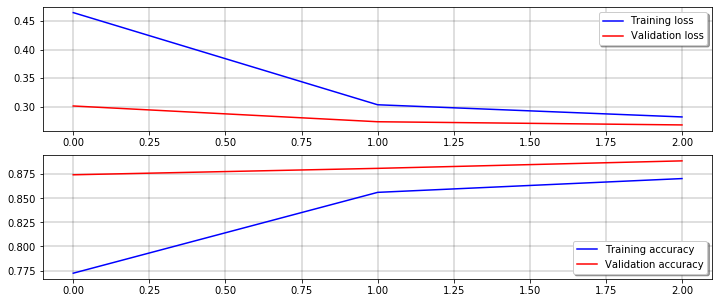

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(12,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

In [28]:
y_pred = keras_model.predict(x_test)

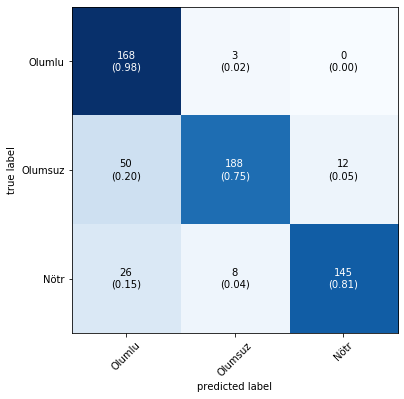

In [29]:
y_pred = keras_model.predict(x_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

class_names = ['Olumlu', 'Olumsuz', 'Nötr']

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                class_names=class_names,
                                figsize =(6,6))